# LangGraph-Travel Advisor

This study explores the development of a Retrieval-Augmented Generation (RAG) agent system. The core libraries employed are LangChain and LangGraph for the the system's architecture, while the Llama3.2 model from Ollama serves as the adopted LLM, providing the main NLP and conversational capabilities. The system integrates Nomic for encoding textual data into dense vector representations, and stores retrieved documents in a Chroma vector database. These technologies allow the system to efficiently handle user queries and generate personalized answers. 

The goal is to build a simple and responsive travel advisor that can adapt to user needs, suggesting destinations, itineraries, and tips based on real-world data. 

## Import

In [ ]:
## Install required packages
%pip install -qU bs4
%pip install -qU chromadb
%pip install -qU tiktoken
%pip install -qU langchain
%pip install -qU langgraph
%pip install -qU langchainhub
%pip install -qU tavily-python
%pip install -qU python-dotenv
%pip install -qU "nomic[local]"
%pip install -qU langchain-nomic
%pip install -qU langchain-ollama
%pip install -qU langchain_community


In [ ]:
## Import
import os
import re
import getpass
import operator
import requests

from bs4 import BeautifulSoup
from dotenv import load_dotenv
from urllib.parse import urljoin
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display
from typing import Annotated, List, Literal

from langchain.schema import Document
from langchain_ollama import ChatOllama
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, StateGraph

import warnings
warnings.filterwarnings("ignore")


In [3]:
## Constants

# URL to crawl to data retrieval
EN_URL = "https://www.italia.it/en"  

# Regions List for URLs
REGIONS = [
    "abruzzo", "aosta-valley", "puglia", "basilicata", "calabria", "campania", "emilia-romagna", 
    "friuli-venezia-giulia", "lazio", "liguria", "lombardy", "marche", "molise", "piedmont", 
    "sardinia", "sicily", "south-tyrol", "trentino", "tuscany", "umbria", "veneto"
]


## APIs

API setup required for the project

In [4]:
## Load APIs from config.env file
load_dotenv(dotenv_path="config.env")

# Nomic and Tavily APIs 
NOMIC_API_KEY = os.getenv("NOMIC_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")


In [7]:
## Without 'config.env' file use the following function
# Setup environment 
def _set_env(key: str) -> None:
    """
    Set the environment variables.
        Args:
            key (str): The name of the environment variable.
    """
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"Enter {key}:")


# Nomic and Tavily APIs 
_set_env("NOMIC_API_KEY")
_set_env("TAVILY_API_KEY")


In [5]:
# # Model & Tool
# LLM 
local_llm = "llama3.2"  
llm = ChatOllama(model=local_llm, temperature=0)

# Initialize Tavily web search tool
tavily_web_search = TavilySearchResults(max_results=3)


## Get Data

In [6]:
# retrieve internal links from a webpage 
def get_internal_links(home_url: str, max_links: int = 10) -> List[str]:
    """
        Retrieves internal links from the given webpage URL.
    
        Args:
            - website_url: The URL of the webpage to crawl.
            - max_links: The maximum number of URLs to retrieve (default is 5).
        Returns:
            A list of internal URLs.
    """
    # Send a request to the website
    response = requests.get(home_url)
    
    # Parse the content of the webpage
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Set of internal links
    internal_links = set()
    
    # Find all <a> tags with href attributes
    for link in soup.find_all("a", href=True):
        # Convert relative URLs to absolute URLs
        href = urljoin(home_url, link["href"])
        
        # Check if the URL starts with the base URL
        if href.startswith(home_url) and '#' not in href:
            internal_links.add(href)
        
        # Stop if we have enough links
        if len(internal_links) >= max_links:
            break
    
    return list(internal_links)


# internal urls
urls = []
# Craw internal URLs
for region in REGIONS:
    base_url = f"{EN_URL}/{region}"  # URL for each region
    internal_urls = get_internal_links(home_url=base_url) # Get internal URLs 
    urls.extend(internal_urls)

# counter = 0
# # Print all internal URLs from all regions
# for internal_url in urls:
#     counter += 1
#     print(internal_url)
# 
# print(f"Counter: {counter}")


## Vectorstore

In [10]:
# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

# Set embeddings
embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")

# Add to vectorstore
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embeddings, persist_directory="./chroma_db")


In [7]:
# Load from disk
database = Chroma(
    persist_directory="./chroma_db", 
    embedding_function=NomicEmbeddings(
        model="nomic-embed-text-v1.5", 
        inference_mode="local"
    ), 
)
# Define the retriever
retriever = database.as_retriever(search_kwargs={"k": 5})


In [8]:
# Test retriever
question_1 = "Where is the Colosseum?"
retrieved_docs = retriever.invoke(question_1)
print(retrieved_docs)


[Document(metadata={'description': 'With an abundance of history, museums and attractions, Rome is a perfect travel destination. Discover the things to see and do.\r\n', 'language': 'en', 'source': 'https://www.italia.it/en/lazio/rome', 'title': 'Rome: Attractions to see & Things to do - Italia.it'}, page_content='Museums and monuments\n\n\n\nLike\n\n\n\n\n\n\n\n\n\n\n\n\n                Colosseum\n            \n\n                \n                    Colosseum one of the 7 Wonders of the World\nThe symbol of the Roman Empire recognized as one of the 7 Wonders of the World, the Flavian Amphitheatre - also known as the Colosseum - is a must-see for anyone visiting Rome. It is the largest amphitheatre in the world, telling the story of the magnificent deeds of gladiators and Ancient Rome. This imposing and evocative place is the most representative icon of Rome and Italy as a whole all over the world; having survived until now, it is a human masterpiece and has always stood out in all it

## Components

### Query is Relevant?

In [9]:
class QueryIsRelevant(BaseModel):
    """
      Verify if the query is relevant to the topic of travel or not.
    """
    subject: Literal["travel", "other"] = Field(
        description="Given a user question choose to route it to 'travel' or 'other'."
    )
    
# LLM
structured_llm_relevant = llm.with_structured_output(QueryIsRelevant)

# System prompt
relevant_instructions = """You are an expert at evaluating the topics of a user question.
Use 'travel' if the question concern the topics and concepts related to travel and tourism. Otherwise, use 'other'.
"""

# Combine the system message and user question in a prompt template
relevant_query_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", relevant_instructions),
        ("human", "{question}"),
    ]
)
relevant_query = relevant_query_prompt | structured_llm_relevant


In [10]:
# # Test relevance
# expected result: vectorstore
relevant_1 = relevant_query.invoke({ 
    "question": question_1
})
print(f"> query's topic: {relevant_1}")

# expected result: web_search
relevant_2 = relevant_query.invoke({ 
    "question": "What is the capital of France?"
})
print(f"> Query's topic: {relevant_2}")


> query's topic: subject='travel'
> Query's topic: subject='other'


### Router

In [11]:
## Router
class QueryRoute(BaseModel):
    """
      Route a user query to the most relevant datasource -> vectorstore or websearch.
    """
    datasource: Literal["vectorstore", "web_search"] = Field(
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM
structured_llm_router = llm.with_structured_output(QueryRoute)

# System prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to some famous italian city, touristic and historical places, food and travel tips for tourists.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# Combine the system message and user question in a prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_instructions),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router


In [12]:
## Test router
# expected result: vectorstore
router_1 = question_router.invoke({ 
    "question": question_1
})
print(f"> query's route: {router_1}")

# expected result: web_search
router_2 = question_router.invoke({ 
    "question": "Where is the Eiffel tower?"
})
print(f"> Query's route: {router_2}")


> query's route: datasource='vectorstore'
> Query's route: datasource='web_search'


### Re-write

In [14]:
## Re-writer
class ReWrite(BaseModel):
    """
        question re-writer.
    """
    rewrite: str = Field(
        description="Re-write the question optimized for retrieval"
    )
    
# LLM
structured_llm_rewriter = llm.with_structured_output(ReWrite)
    
# System prompt
re_write_instructions = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", re_write_instructions),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question.",),
    ]
)
question_rewriter = re_write_prompt | structured_llm_rewriter


In [15]:
## Test question re-writer 
rewriter = question_rewriter.invoke({
    "question": question_1
})
print(f"> Re-written query: {rewriter}")


> Re-written query: rewrite='What is the location of the Colosseum?'


### Docs Relevance

In [16]:
## Docs are relevant or not
class GradeDocs(BaseModel):
    """
        Binary score for relevance check on retrieved documents.
    """
    relevance: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM
structured_llm_retrieval = llm.with_structured_output(GradeDocs)

# System prompt
doc_grader_instructions = """
You are a grader assessing relevance of a retrieved document to a user question.  
If the document contains keyword(s), shares concepts or semantic meaning related to the user question, grade it as relevant. 
It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", doc_grader_instructions),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_retrieval


In [17]:
## Test grader
# First question: expected score = yes
docs_text_1 = retrieved_docs[0]
is_relevant_1 = retrieval_grader.invoke({"question": question_1, "document": docs_text_1})
print(f"> Query is relevant: {is_relevant_1}")

# Second question: expected score = no
question_2 = "Where is the Eiffel tower?"   
retrieve_document_2 = retriever.invoke(question_2) 
docs_text_2 = retrieve_document_2[0]
is_relevant_2 = retrieval_grader.invoke({"question": question_2, "document": docs_text_2})
print(f"> Query is relevant: {is_relevant_2}")

> Query is relevant: relevance='yes'
> Query is relevant: relevance='no'


### Planning

In [18]:
# System prompt
planner_instructions = """
You are an expert travel planner with a kind and friendly personality. Always start the conversation by saying hello. You're excited to help travelers plan their perfect vacation with engaging and heartfelt recommendations. Present the information as if you are talking to a friend, making sure to be warm, conversational, and enthusiastic about the places to visit, the local cuisine, and tips for the trip. Make it feel like a personal guide. Don't be concise, but be conversational.

Question: {question}
Context: {context}

Plan:
- **Places to Visit**: 
    Start by warmly describing the main attractions, what makes them special, and why they're must-sees. Use friendly language like "You’ll love visiting..." or "Make sure to check out..."
    
- **Recommended Itineraries**: 
    Suggest possible itineraries that would help travelers make the most of their time. Use phrases like "If you have 3 days, I recommend starting with..." or "For a week-long trip, here's how you could plan each day..." to give them flexible but structured options.
    
- **Local Cuisine**: 
    Describe the local dishes with enthusiasm, like you're sharing a favorite meal with a friend. Phrases like "You can't leave without trying..." or "One bite of this and you'll see why it's a local favorite..." will make it feel personal.

- **Tips for Travelers**: 
    Offer helpful advice as if you're giving insider knowledge, with kind reminders like "Don’t forget to bring..." or "It's always good to know that..."

End with a friendly closing note like: "I hope you have an amazing time! Safe travels!"
"""
planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", planner_instructions),
        ("human", "Question: \n\n {question}"),
    ]
)
plan_chain = planner_prompt | llm | StrOutputParser()


In [19]:
## Post-processing
def format_docs(documents):
    """
    Formats and cleans the page contents of documents into a single string.

    Args:
        documents (list): A list of document objects, each containing a 'page_content' attribute.

    Returns:
        str: A single cleaned string containing the combined page contents,
              with excessive whitespace removed.
    """
    # Combine page contents
    combined_text = "\n\n".join(doc.page_content for doc in documents)

    # Removing excessive whitespace
    cleaned_text = re.sub(r'\s+', ' ', combined_text).strip()

    return cleaned_text

In [20]:
## Test planner
planner_docs = retriever.invoke(question_1)
planner_docs_txt = format_docs(planner_docs)

generated_plan = plan_chain.invoke({
    "context": planner_docs_txt, 
    "question": question_1,
})
print(f"> Plan:\n{generated_plan}")


> Plan:
Hello! I'm so excited to help you plan your trip!

The Colosseum is one of the most iconic landmarks in Rome, Italy, and it's a must-see for anyone visiting this incredible city. Located in the heart of Rome, the Colosseum is situated in the Lazio region, near the Roman Forum and other ancient ruins.

Imagine walking through the historic center of Rome, surrounded by ancient architecture, street performers, and delicious food – that's where you'll find the Colosseum! It's a short walk from many popular attractions, including the Roman Forum, the Pantheon, and the Trevi Fountain.

The address is: Piazza del Colosseo, 00187 Roma RM, Italy

You can't miss it! The Colosseum is an imposing structure that dominates the cityscape, with its massive stone walls and towering arches. It's a testament to the engineering and architectural skills of the ancient Romans.

When you visit the Colosseum, be sure to explore the surrounding area, which offers stunning views of the city and insights

### Check Coherency

In [21]:
## Coherence grader
class GradeCoherence(BaseModel):
    """
        Binary score for planner answer coherency.
    """
    coherence: str = Field(
        description="Answer is consistent with the documents, 'yes' or 'no'"
    )
    
# LLM
structured_llm_coherence = llm.with_structured_output(GradeCoherence)

# System prompt
coherency_instructions = """
You are a rater who evaluates whether the planner is consistent with the information in the documents. 
You assign a binary score of "yes" or "no". "yes" means the answer is consistent with the documents."""

coherence_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", coherency_instructions),
        ("human", "documents: \n\n {documents} \n\n planner: {planner}"),
    ]
)
coherence_grader = coherence_prompt | structured_llm_coherence


In [22]:
## Test Coherency
coherency = coherence_grader.invoke({
    "documents": planner_docs_txt,  
    "planner": generated_plan  
})
print(f"> Answer is coherent: {coherency}")


> Answer is coherent: coherence='yes'


### Answer evaluation

In [23]:
## Answer Grader
class GradeAnswers(BaseModel):
    """
        Binary score to assess answer addresses question.
    """
    evaluation: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )
    
# LLM
structured_llm_grader = llm.with_structured_output(GradeAnswers)

# System prompt
answer_grader_instructions = """
You are a grader assessing whether the planner addresses / resolves a request
Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the request."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_instructions),
        ("human", "User question: \n\n {question} \n\n Planner: {planner}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader


In [24]:
## Test grade answer
grade_answer = answer_grader.invoke({
    "question": question_1, 
    "planner": generated_plan
})
print(f"> Answer 'resolve' the query: {grade_answer}")


> Answer 'resolve' the query: evaluation='yes'


# Tavily: web search tool

In [25]:
# Test Tavily 
test_web_search = tavily_web_search.invoke({
    "query": "What is the answer to the ultimate question of life, the universe, and everything?"
})
print(f"Web search results: {test_web_search}")

Web search results: [{'url': 'https://simple.wikipedia.org/wiki/42_(answer)', 'content': '42 (answer) 42 is the "Answer to the Ultimate Question of Life, the Universe, and Everything" in The Hitchhiker\'s Guide to the Galaxy books. It was computed by Deep Thought, the second greatest computer ever. [1] The descendants of Deep Thought\'s creators are upset by the numeric nature of the answer, not understanding what to do with it or'}, {'url': 'https://hitchhikers.fandom.com/wiki/42', 'content': '42 (or forty-two) is the Answer to the Ultimate Question of Life, the Universe and Everything. This Answer was first calculated by the supercomputer Deep Thought after seven and a half million years of thought. This shocking answer resulted in the construction of an even larger supercomputer, named Earth, which was tasked with determining what the question was in the first place. The Earth was'}, {'url': 'https://quoteinvestigator.com/2022/10/29/answer-universe/', 'content': "The fourth episode 

## Graph: State

In [26]:
# Graph's state
class State(TypedDict):
    """
    Represents the state of the graph.

    Attributes:
        documents: list of documents.
        max_retries: the maximum number of hallucination checks permitted.
        loop_step: Indicates the current step in a looping process.
        planner: LLM planning.
        question: question.
        web_search: run web search
    """
    documents: List[str]
    max_retries: int
    loop_step: Annotated[int, operator.add]
    planner: str
    route: str
    topic: str
    question: str
    web_search: str
    

### Graph: Nodes

In [27]:
# Node: query subject
def subject(state: State) -> dict:
    """
        Get the subject of the user query
        Args:
            state: The current graph state 
        Returns:
            Updates subject key based on the user query
    """
    print("---ESTABLISH SUBJECT---")
    question = state["question"]
    
    subject_score = relevant_query.invoke({
        "question": question
    })
    # Return state
    return {"topic": subject_score, "question": question}


# Node: off-topic response
def standard_reply(state: State) -> dict:
    """
    Responds with a standard message.

    Args:
        The current state of the graph.
    Returns:
        Updates planner key.
    """
    # Standard response message to inform the user.
    standard_response = (
        "Hello! I'm your travel assistant, and I can help with questions related to travel."
    )
    # Update the state
    state["planner"] = standard_response
    
    # Return state 
    return {"planner": state["planner"]}


# Node: query route
def router(state: State) -> dict:
    """
        Get the route of the user query
    
        Args:
            state (dict): The current graph state   
        Returns:
            Updates route key based on the relevant user query
    """
    print("---ESTABLISH ROUTE---")
    question = state["question"]
    
    route_score = question_router.invoke({
        "question": question
    }) 
    # Return state
    return {"route": route_score, "question": question}

    
# Node: retrieve documents
def retrieve(state: State) -> dict:
    """
        Retrieve documents from vectorstore
    
        Args:
            state: The current graph state
        Returns:
            state: Updates documents key with only filtered relevant documents
    """
    print("---RETRIEVE DOCS---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    
    return {"documents": documents, "question": question}


# Node: docs are relevant or not
def grade_documents(state: State) -> dict:
    """
        Determines whether the retrieved documents are relevant to the question.
    
        Args:
            state: The current graph state.
        Returns:
            Updates the web_search key and the documents key with only the relevant documents.
    """
    print("---CHECK DOCUMENT RELEVANCE---")
    question = state["question"]    
    documents = state["documents"] 

    relevant_documents = []
    select_web= "NO"
    yes_count = 0
    
    for doc in documents:
        retrieval_score = retrieval_grader.invoke({
            "question": question, 
            "document": doc.page_content
        })
        retrieval_grade = retrieval_score.relevance
        
        if retrieval_grade == "yes":
            print("---DOCUMENT RELEVANCE---")
            relevant_documents.append(doc)
            yes_count += 1
        else:
            print("---DOCUMENT NOT RELEVANCE---")
            # select_web = "yes"
            continue
            
    # Set web_search to "yes" only if the majority of docs are graded as "no"
    total_docs = len(documents)
    if yes_count <= total_docs // 2:
        select_web = "YES"
    
    return {"documents": relevant_documents, "web_search": select_web}


# Node: optimize query
def rewrite_query(state: State) -> dict:
    """
        Transform the query to produce a better question.

        Args:
            state: The current graph state.
        Returns:
            Updates question key with a re-phrased question.
    """
    print("---RE-WRITE QUESTION---")
    question = state["question"]

    # Re-write question
    re_write_query = question_rewriter.invoke({
        "question": question
    })
    better_question = re_write_query.rewrite

    return {"question": better_question}


# Node: planning
def planner(state: State) -> dict:
    """
        Generates a plan based on the provided query.
        
        Args:
            state: The current graph state.
        Returns:
            Updates planner key with the plan and
            the loop step, incremented by 1.
    """
    print("---PLANNER---")
    question = state["question"]            
    documents = state["documents"]          
    loop_step = state.get("loop_step", 0)   
    
    # RAG planning
    make_plan = plan_chain.invoke({
        "context": documents,
        "question": question
    })
    # Return state
    return {"documents": documents, "question": question, "planner": make_plan, "loop_step": loop_step + 1}


# Node: search on the web
def web_search(state: State) -> dict:
    """
    Web search based on the query.

    Args:
        state: The current graph state
    Returns:
        Updates documents key with appended web results
    """
    print("---WEB-SEARCH---")
    question = state["question"]          
    documents = state.get("documents", []) 

    # Perform a web search using the Tavily
    web_docs = tavily_web_search.invoke({"query": question})
    web_results = "\n".join([doc["content"] for doc in web_docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    # Return state
    return {"documents": documents, "question": question}
    

### Graph: Edges

In [28]:
# Edge: 'off-topic' or 'on-topic'
def route_subject(state: State) -> str:
    """
        Route question to travel or other.
    
        Args:
            state: The current graph state
        Returns:
            Next node to call
    """
    topic = state["topic"]
    topic_grade = topic.subject
    
    # Determine if subject is off-topic or not
    if topic_grade == "other":
        print("===SUBJECT: OTHER===")
        return "off-topic"
    elif topic_grade == "travel":
        print("===SUBJECT: TRAVEL===")
        return "on-topic"
    
    
# Edge: RAG or web
def route_question(state: State) -> str:
    """
        Route question to web search or RAG.
    
        Args:
            state (dict): The current graph state
        Returns:
            Next node to call.
    """
    source = state["route"]
    source_grade = source.datasource
    
    # Decide if route to 'web_search' or 'vectorstore'
    if source_grade == "web_search": 
        print("===ROUTE: WEB SEARCH===")
        return "websearch"    
    elif source_grade == "vectorstore":
        print("===ROUTE: RAG===")
        return "vectorstore"
    

# Edge: planner or web_search
def decide_to_plan(state: State) -> str:
    """
    Determines if use the planner, ot the web_search.

    Args:
        state: The current graph state.
    Returns:
        Next node to call.
    """
    print("===EVALUATE DOCUMENTS===")
    # question = state["question"]
    go_to_web = state["web_search"]
    # filtered_documents = state["documents"]
    
    if go_to_web == "YES":
        print("===DECISION: GO TO WEB-SEARCH===")
        return "websearch"
    else: 
        print("===DECISION: GO TO PLANNER===")
        return "travel_planner"


# Edge: check and decide how to answer
def check_and_answer(state: State) -> str:
    """
    Determines whether the planning is coherent and answers question.

    Args:
        state: The current graph state
    Returns:
        Next node to call.
    """
    print("===CHECK COHERENCY===")
    question = state["question"]
    documents = state["documents"]
    loop_step = state["loop_step"]
    max_retries = state.get("max_retries", 3)
    plan = state["planner"]
    
    coherence_score = coherence_grader.invoke({
        "documents": format_docs(documents), 
        "planner": plan
    })
    coherence_grade = coherence_score.coherence
    
    # Check hallucination
    if coherence_grade == "yes":
        print("===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===")
        
        # Check question-answering
        print("===EVALUATE PLANNER ANSWER===")
        answer_score = answer_grader.invoke({
            "question": question,
            "planner": plan
        })
        answer_grade = answer_score.evaluation 
        
        if answer_grade == "yes":
            print("===DECISION: PLANNER ADDRESSES QUESTION===")
            return "useful"
        elif loop_step <= max_retries:
            print("===DECISION: PLANNER DOES NOT ADDRESS QUESTION===")
            return "not useful"
        else:
            print("===DECISION: MAX RETRIES REACHED===")
            return "max retries"
    elif loop_step <= max_retries:
        print(f"===DECISION: PLANNER IS NOT COHERENT WITH THE DOCUMENTS, RE-TRY===")
        return "check_coherency"
    else:
        print("===DECISION: MAX RETRIES REACHED===")
        return "max retries"


### Build the graph

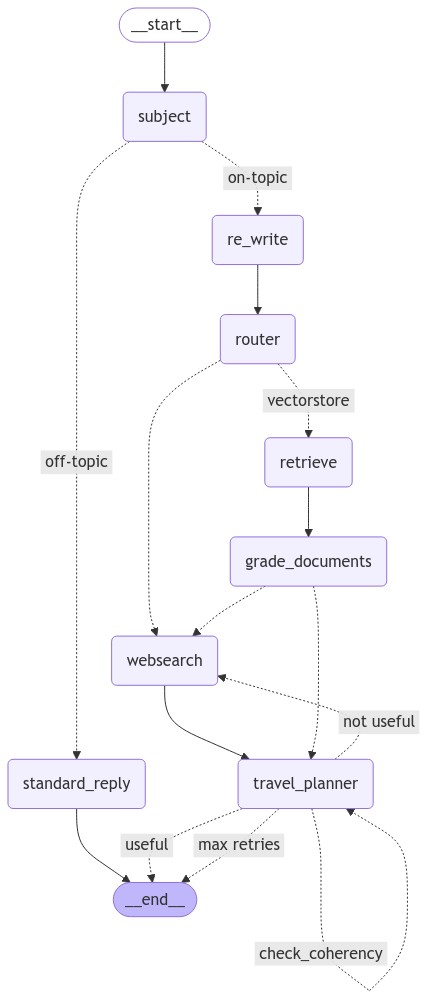

In [29]:
# Graph's state
workflow = StateGraph(State)

# Define the nodes
workflow.add_node(node="subject", action=subject)
workflow.add_node(node="standard_reply", action=standard_reply)
workflow.add_node(node="router", action=router)
workflow.add_node(node="re_write", action=rewrite_query)
workflow.add_node(node="retrieve", action=retrieve)                 
workflow.add_node(node="grade_documents", action=grade_documents)   
workflow.add_node(node="websearch", action=web_search)              
workflow.add_node(node="travel_planner", action=planner)           

# Flow: edges and condition
workflow.add_edge(START, "subject")
workflow.add_conditional_edges(
    "subject",
    route_subject,
    {
        "on-topic": "re_write",
        "off-topic": "standard_reply",
    }
)
workflow.add_edge("standard_reply", END)
workflow.add_edge("re_write", "router")

workflow.add_conditional_edges(
    "router",
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("websearch", "travel_planner")
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_plan,
    {
        "websearch": "websearch",
        "travel_planner": "travel_planner",
    },
)

workflow.add_conditional_edges(
    "travel_planner",
    check_and_answer,
    {
        "check_coherency": "travel_planner",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
# Display the graph
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))


In [78]:
# Test Graph: RAG
answer = graph.invoke({
    "question":"Hi, I'd like to plan a vacation in Italy, in the Sardinia region. What do you suggest me?"
})["planner"]

print(f"\nTravel Planner:\n{answer}")


---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---RE-WRITE QUESTION---
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
===EVALUATE DOCUMENTS===
===DECISION: GO TO PLANNER===
---PLANNER---
===CHECK COHERENCY===
===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===
===EVALUATE PLANNER ANSWER===
===DECISION: PLANNER ADDRESSES QUESTION===

Travel Planner:
Sardinia is a beautiful island in the Mediterranean Sea, known for its stunning beaches, crystal-clear waters, and rich history and culture. Here are some suggestions for your vacation:

**Must-see destinations:**

1. **Costa Smeralda**: A picturesque coastline with turquoise waters and white-sand beaches.
2. **Cagliari**: The capital city of Sardinia, known for its historic center, Roman amphitheater, and stunning cathedral.
3. **Alghero**: A charming coastal town with a be

In [31]:
# Test Graph: RAG
answer = graph.invoke({
    "question":"Hi, can you help me define an itinerary in the city of Verona?"
})["planner"]

print(f"\nTravel Planner:\n{answer}")


---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---RE-WRITE QUESTION---
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
===EVALUATE DOCUMENTS===
===DECISION: GO TO PLANNER===
---PLANNER---
===CHECK COHERENCY===
===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===
===EVALUATE PLANNER ANSWER===
===DECISION: PLANNER ADDRESSES QUESTION===

Travel Planner:
Hello! I'm so excited to help you plan your trip to Verona, one of the most romantic cities in Italy. You'll love visiting this beautiful city, steeped in history and culture.

Verona is famous for being the setting of Shakespeare's Romeo and Juliet, and it's easy to see why - the city's stunning architecture, picturesque streets, and charming piazzas all come together to create a magical atmosphere. Here's a suggested 2-day itinerary to help you make the most of you

In [41]:
# Test Graph: RAG
answer = graph.invoke({
    "question":"What are the must-visit historical landmarks in Tuscany, and how can I plan a week-long trip around them?",
})["planner"]

print(f"\nTravel Planner:\n{answer}")

---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---RE-WRITE QUESTION---
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT RELEVANCE---
===EVALUATE DOCUMENTS===
===DECISION: GO TO PLANNER===
---PLANNER---
===CHECK COHERENCY===
===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===
===EVALUATE PLANNER ANSWER===
===DECISION: PLANNER ADDRESSES QUESTION===

Travel Planner:
Tuscany, Italy is known for its rich history, art, architecture, and natural beauty. Here's a suggested 7-day itinerary for visiting the top historical attractions in Tuscany:

Day 1: Florence

* Start your journey in Florence, the birthplace of the Renaissance.
* Visit the Uffizi Gallery (Galleria degli Uffizi), which houses some of the world's most famous paintings, including Botticelli's "The Birth of Venus."
* Explore the Duomo Complex, which includes the Cathedr

In [42]:
# Test Graph: RAG -> WebSearch
answer = graph.invoke({
    "question":"What are the best hiking trails in the Dolomites, and how should I prepare for a trip in South Tyrol?",
})["planner"]

print(f"\nTravel Planner:\n{answer}")

---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---RE-WRITE QUESTION---
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
===EVALUATE DOCUMENTS===
===DECISION: GO TO WEB-SEARCH===
---WEB-SEARCH---
---PLANNER---
===CHECK COHERENCY===
===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===
===EVALUATE PLANNER ANSWER===
===DECISION: PLANNER ADDRESSES QUESTION===

Travel Planner:
Hello! I'm so excited to help you plan your adventure in the breathtaking Dolomites and South Tyrol!

The Dolomites are a UNESCO World Heritage Site, and for good reason - these mountains offer some of the most stunning scenery on the planet. With over 1,500 square kilometers of protected area, there's no shortage of hiking trails to explore. Let me tell you about some of my favorites!

**Must-see Hiking Trails:**

1. **Tre Cime di Lavaredo**:

In [43]:
# Test Graph: RAG
answer = graph.invoke({
    "question":"How can I plan an itinerary through Umbria to experience its medieval towns and wine tours?",
})["planner"]

print(f"\nTravel Planner:\n{answer}") 
    
    

---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---RE-WRITE QUESTION---
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
---DOCUMENT RELEVANCE---
===EVALUATE DOCUMENTS===
===DECISION: GO TO PLANNER===
---PLANNER---
===CHECK COHERENCY===
===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===
===EVALUATE PLANNER ANSWER===
===DECISION: PLANNER ADDRESSES QUESTION===

Travel Planner:
Umbria is a beautiful region in central Italy known for its rolling hills, charming medieval towns, and excellent wines. Here's a suggested 7-day itinerary for you:

Day 1: Arrival in Perugia

* Arrive in Perugia, the capital city of Umbria
* Explore the historic center, including the Piazza IV Novembre and the Palazzo dei Priori
* Visit the Perugina chocolate factory to learn about the famous Bacio chocolates
* Overnight in Perugia

Day 2: Spoleto and Wine Tasting

* Drive 

In [56]:
# Test Graph: WebSearch
answer = graph.invoke({
    "question":"What kind of food I can eat while visiting Paris?"
})["planner"]

print(f"\nTravel Planner:\n{answer}")


---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---RE-WRITE QUESTION---
---ESTABLISH ROUTE---
===ROUTE: WEB SEARCH===
---WEB-SEARCH---
---PLANNER---
===CHECK COHERENCY===
===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===
===EVALUATE PLANNER ANSWER===
===DECISION: PLANNER ADDRESSES QUESTION===

Travel Planner:
Hello! I'm so excited to talk about the food scene in Paris, one of my favorite cities in the world. You'll be delighted to know that French cuisine is renowned for its rich flavors, intricate preparations, and exquisite presentation. When it comes to eating in Paris, you're spoiled for choice with a diverse range of delicious options.

First of all, let's start with some classic French dishes that are absolute must-tries when visiting the city. You'll love trying a traditional Croque Monsieur or Madame, which is essentially a grilled ham and cheese sandwich that's perfect for breakfast, lunch, or dinner. These sandwiches are made to perfection, and I just can't recommend them 

In [57]:
# Test Graph: WebSearch
answer = graph.invoke({
    "question":"What are the top tourist attractions to explore in Kyoto, Japan, during the cherry blossom season?"
})["planner"]

print(f"\nTravel Planner:\n{answer}")


---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---RE-WRITE QUESTION---
---ESTABLISH ROUTE---
===ROUTE: RAG===
---RETRIEVE DOCS---
---CHECK DOCUMENT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
---DOCUMENT NOT RELEVANCE---
===EVALUATE DOCUMENTS===
===DECISION: GO TO WEB-SEARCH===
---WEB-SEARCH---
---PLANNER---
===CHECK COHERENCY===
===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===
===EVALUATE PLANNER ANSWER===
===DECISION: PLANNER ADDRESSES QUESTION===

Travel Planner:
Hello! I'm so excited to help you plan your trip to Kyoto, Japan during the breathtaking cherry blossom season. This is one of my favorite times of year to visit this beautiful city, and I just know you'll fall in love with it too!

When it comes to top tourist attractions in Kyoto during peak sakura season (usually around March 27 to April 3), there are so many incredible spots to explore. Let me tell you about some of my favorites.



In [58]:
# Test Graph: WebSearch
answer = graph.invoke({
    "question":"Which cities in New Zealand offer the best adventure activities, from bungee jumping to glacier hikes?"
})["planner"]

print(f"\nTravel Planner:\n{answer}")

---ESTABLISH SUBJECT---
===SUBJECT: TRAVEL===
---RE-WRITE QUESTION---
---ESTABLISH ROUTE---
===ROUTE: WEB SEARCH===
---WEB-SEARCH---
---PLANNER---
===CHECK COHERENCY===
===DECISION: PLANNER IS COHERENT WITH THE DOCUMENTS===
===EVALUATE PLANNER ANSWER===
===DECISION: PLANNER ADDRESSES QUESTION===

Travel Planner:
Hello there, fellow travel enthusiast! I'm so excited to help you plan your next adventure in New Zealand. You're looking for some of the best cities to experience thrilling activities like bungee jumping and glacier hiking, right?

Well, let me tell you, Queenstown is often referred to as the adventure capital of the world, and for good reason! It's a paradise for thrill-seekers and outdoor enthusiasts. You'll find plenty of opportunities for bungee jumping, skydiving, white-water rafting, and more. The stunning scenery and breathtaking views make it an absolute must-visit destination.

One of the most iconic activities in Queenstown is bungee jumping off the Kawarau Bridge, w

In [32]:
# Test Graph: Off-topic query
answer = graph.invoke({
    "question":"Who won the 2024 Olympics?"
})["planner"]

print(f"\nTravel Planner:\n{answer}")


---ESTABLISH SUBJECT---
===SUBJECT: OTHER===

Travel Planner:
Hello! I'm your travel assistant, and I can help with questions related to travel.
